# 1. Setup

# 1.1 Install Dependencies


In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib


# 1.2 Imports Dependencies

In [1]:
# Import standard dependencies
import cv2 
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 1.4 Creates Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'data\\positive'

# 2. Collect Positives and Anchors

# 2.2 Collect Positive and Anchor Classes

In [6]:
# http://vis-www.cs.umass.edu/lfw/

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'lfw'

In [8]:
# Import uuid libary to generate unique image names
import uuid

In [9]:
os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\positive\\004b7ab8-67aa-11ec-9df1-402cf48b34da.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

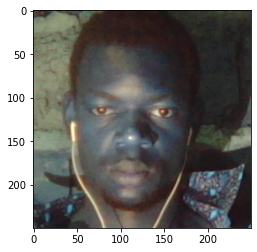

In [11]:
plt.imshow(frame[:120+250,:200+250,:])

# 3. Load and Preprocess Images

# 3.1 Get Image Directories

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data\\anchor\\67e9472b-5d16-11ec-b448-402cf48b34da.jpg'


# 3.2 Preprocessing - Scale Resize

In [15]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resezing the image to the 100x100x3
    img = tf.image.resize(img, (100,100))
     # Scale image to be between 0 and 1
    img = img / 255.0
    
    
    return img

In [16]:
img = preprocess(b'data\\anchor\\5ea4a849-5d16-11ec-a883-402cf48b34da.jpg')

In [17]:
img.numpy().min()

0.23284313

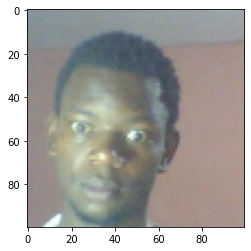

In [18]:
plt.imshow(img)

In [19]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

# 3.3 Create Labelled Dataset

In [20]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [21]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
samples = data.as_numpy_iterator()

In [23]:
example = samples.next()

In [24]:
example

(b'data\\anchor\\645f7439-5d16-11ec-8dc5-402cf48b34da.jpg',
 b'data\\positive\\b7016e21-5d17-11ec-b8a4-402cf48b34da.jpg',
 1.0)

# 3.4 Build Train and Test Partition

In [25]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [26]:
res = preprocess_twin(*example)

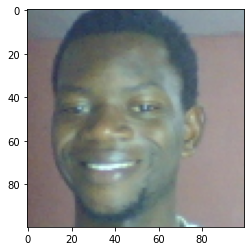

In [27]:
plt.imshow(res[1])

In [28]:
res[2]

1.0

In [29]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [30]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [31]:
# Testin partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

# 4.1 Build Embedding Layer

In [32]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128,(7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
    
    # Third block
    c3 = Conv2D(128,(4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

# 4.2 Build Distance Layer

In [35]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

In [37]:
l1

# 4.3 Make Siamese Model

In [38]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork') 

In [39]:
siamese_model = make_siamese_model()

In [40]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# 5. Training

# 5.1 Setup Loss and Optimizer

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
opt = tf.keras.optimizers.Adam(1e-4)#0.0001

# 5.2 Establish Checkpoints

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

# 5.3 Build Train Step Function

In [44]:
test_batch = train_data.as_numpy_iterator()

In [45]:
batch_1 = test_batch.next()

In [46]:
x = batch_1[:2]

In [47]:
y = batch_1[2]

In [48]:
y

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [49]:
tf.losses.BinaryCrossentropy??

In [50]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

# 5.4 Build Training Loop

In [51]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
      
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# 5.5 Train the model

In [67]:
EPOCHS = 50

In [68]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
58/58 [==============================] - 2577s 44s/step

 Epoch 2/50
58/58 [==============================] - 2709s 47s/step

 Epoch 3/50
58/58 [==============================] - 2718s 47s/step

 Epoch 4/50
58/58 [==============================] - 2766s 48s/step

 Epoch 5/50
58/58 [==============================] - 2738s 47s/step

 Epoch 6/50
58/58 [==============================] - 2735s 47s/step

 Epoch 7/50
58/58 [==============================] - 2725s 47s/step

 Epoch 8/50
58/58 [==============================] - 2729s 47s/step

 Epoch 9/50
58/58 [==============================] - 2721s 47s/step

 Epoch 10/50
58/58 [==============================] - 2735s 47s/step

 Epoch 11/50
58/58 [==============================] - 2714s 47s/step

 Epoch 12/50
58/58 [==============================] - 2636s 45s/step

 Epoch 13/50
5

# 6. Evaluate Model

# 6.1  Import Metrics

In [108]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# 6.2 Make Predictions

In [109]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [110]:
y_hat = siamese_model.predict([test_input, test_val])

In [111]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.5089718 ],
       [0.50670713],
       [0.5023792 ],
       [0.50744206],
       [0.5091897 ],
       [0.50803274],
       [0.50742596],
       [0.5007304 ],
       [0.5071075 ],
       [0.5095933 ],
       [0.5015462 ],
       [0.5051393 ],
       [0.5054533 ],
       [0.5018363 ],
       [0.5069852 ],
       [0.50758636]], dtype=float32)

In [112]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [113]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

# 6.3 Calculate Metrics

In [114]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [115]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.125

# 6.4 Viz Result

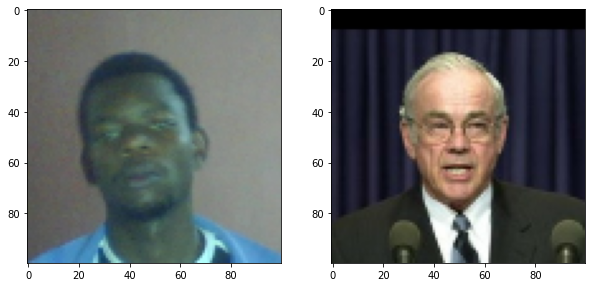

In [116]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders clearly
plt.show()

# 7. Save Model

In [79]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [80]:
# Reload model
model =tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [100]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[0.50543153],
       [0.5067177 ],
       [0.51017636],
       [0.5064679 ],
       [0.50732416],
       [0.5032936 ],
       [0.5049092 ],
       [0.5075608 ],
       [0.5010354 ],
       [0.5061274 ],
       [0.5057567 ],
       [0.5089718 ],
       [0.5057545 ],
       [0.5061909 ],
       [0.50928336],
       [0.5040569 ]], dtype=float32)

In [101]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

# 8.1 Verification Function

In [73]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (<ipython-input-73-10b5f818160f>, line 1)

In [74]:
os.listdir(os.path.join('application_data', 'verification_images'))

['008bb3ea-5d1f-11ec-8026-402cf48b34da.jpg',
 '00c2e766-5d1f-11ec-98ab-402cf48b34da.jpg',
 '02f72104-5d1f-11ec-95f5-402cf48b34da.jpg',
 '05d1443d-5d1f-11ec-976a-402cf48b34da.jpg',
 '07048b2c-5d1f-11ec-95dd-402cf48b34da.jpg',
 '1d6b6472-5d18-11ec-8639-402cf48b34da.jpg',
 '1de2cbd5-5d18-11ec-8d89-402cf48b34da.jpg',
 '1e5aa737-5d18-11ec-a7f0-402cf48b34da.jpg',
 '1e6d4202-5d18-11ec-8294-402cf48b34da.jpg',
 '1e9313e4-5d18-11ec-992e-402cf48b34da.jpg',
 '1f7030e6-5d18-11ec-a2ad-402cf48b34da.jpg',
 '1f838e9e-5d18-11ec-9267-402cf48b34da.jpg',
 '1f9650bb-5d18-11ec-992a-402cf48b34da.jpg',
 '1fd5993c-5d18-11ec-91a9-402cf48b34da.jpg',
 '1fe8828c-5d18-11ec-b12a-402cf48b34da.jpg',
 '22ba93aa-5d18-11ec-81c4-402cf48b34da.jpg',
 '24ecf95c-5d18-11ec-986a-402cf48b34da.jpg',
 '2683d47f-5d18-11ec-a262-402cf48b34da.jpg',
 '28e72d2b-5d18-11ec-9107-402cf48b34da.jpg',
 '2a99a3e1-5d18-11ec-91b2-402cf48b34da.jpg',
 '2b11cd95-5d18-11ec-ac9f-402cf48b34da.jpg',
 '2c01d3c5-5d18-11ec-8f23-402cf48b34da.jpg',
 '2e19d746

In [75]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [76]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\008bb3ea-5d1f-11ec-8026-402cf48b34da.jpg
application_data\verification_images\00c2e766-5d1f-11ec-98ab-402cf48b34da.jpg
application_data\verification_images\02f72104-5d1f-11ec-95f5-402cf48b34da.jpg
application_data\verification_images\05d1443d-5d1f-11ec-976a-402cf48b34da.jpg
application_data\verification_images\07048b2c-5d1f-11ec-95dd-402cf48b34da.jpg
application_data\verification_images\1d6b6472-5d18-11ec-8639-402cf48b34da.jpg
application_data\verification_images\1de2cbd5-5d18-11ec-8d89-402cf48b34da.jpg
application_data\verification_images\1e5aa737-5d18-11ec-a7f0-402cf48b34da.jpg
application_data\verification_images\1e6d4202-5d18-11ec-8294-402cf48b34da.jpg
application_data\verification_images\1e9313e4-5d18-11ec-992e-402cf48b34da.jpg
application_data\verification_images\1f7030e6-5d18-11ec-a2ad-402cf48b34da.jpg
application_data\verification_images\1f838e9e-5d18-11ec-9267-402cf48b34da.jpg
application_data\verification_images\1f9650bb-5d18-11ec-992a-402

In [77]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
         # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# 8.2 OpenCv Real Time Verification

In [99]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
True
True
True
True
True
